In [263]:
import requests
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from matplotlib.pyplot import figure
import plotly.express as px
from mplcursors import cursor  # separate package must be installed
from os import listdir



import utils


In [193]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# https://www.kaggle.com/code/sahilgarg108/hyperparameter-tuning-92-f1-auc-roc
# https://www.fao.org/faostat/en/#data/QCL
# FAOSTAT_data_en_4-21-2024.csv
# https://www.kirenz.com/blog/posts/2022-06-17-sentiment-analysis-with-tensorflow-and-keras/

# FAO
# https://www.fao.org/faostat/en/#data/RFB -- > Fertilizer use
# https://www.fao.org/faostat/en/#data/QCL --> Crops and livestock products

# World Bank Indicators 
# https://data.worldbank.org/indicator
# https://databank.worldbank.org/reports.aspx?source=2&series=NV.AGR.TOTL.ZS&country=

# https://www.ers.usda.gov/webdocs/outlooks/40408/30645_wrs0404e_002.pdf

# Austria Belgium Denmark  France Finland 
# Germany Greece Italy Netherlands 
# Portugal Spain Sweden UK


In [ ]:
# Time series analysis
# https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python


In [257]:
# Returns a cleaned up dataframe with columns dropped and column names converted into 'variable name' like format
def do_basic_cleanup(df, drop_cols):
    df = df.rename(columns={c: c.lower().replace(" ", "_").replace("(", "").replace(")", "") for c in df.columns})
    try:
      df = df.drop(columns=drop_cols)
    except Exception as e:
      print(e)
    return df

In [298]:
df = pd.DataFrame()

for file in listdir('data'):
  df_part = pd.read_csv("data/" + file, on_bad_lines='warn')
  df_part = do_basic_cleanup(df_part, ['domain_code', 'area_code_m49', 'element_code', 'item_code_cpc', 'year_code', 'note', 'flag'])
  print(file, df_part.shape)
  df = pd.concat([df, df_part], ignore_index=True)

FAOSTAT_data_en_4-28-2024_Port_Swe.csv (41402, 8)
FAOSTAT_data_en_4-28-2024_Ger_Neth.csv (55646, 8)
FAOSTAT_data_en_4-28-2024_Aust_Fin.csv (46988, 8)
FAOSTAT_data_en_4-28-2024_IRL.csv (6452, 8)


In [299]:
df.value = df.value.astype('int64')
df.shape
df.head()

(150488, 8)

,domain,area,element,item,year,unit,value,flag_description
0,Crops and livestock products,Portugal,Area harvested,"Almonds, in shell",1961,ha,37000,Estimated value
1,Crops and livestock products,Portugal,Yield,"Almonds, in shell",1961,100 g/ha,4324,Estimated value
2,Crops and livestock products,Portugal,Production,"Almonds, in shell",1961,t,16000,Official figure
3,Crops and livestock products,Portugal,Area harvested,"Almonds, in shell",1962,ha,38000,Estimated value
4,Crops and livestock products,Portugal,Yield,"Almonds, in shell",1962,100 g/ha,4737,Estimated value


In [300]:
df.unit.value_counts()

unit
t           61419
ha          49394
100 g/ha    39675
Name: count, dtype: int64

In [301]:
def calc_means(df):
  df = df[['item', 'element', 'area', 'value']]
  return df.groupby(by=['item', 'element', 'area'], as_index=False).mean()

means_df = calc_means(df).rename(columns={'value': 'all_time_mean'})
means_df.all_time_mean = means_df.all_time_mean.apply(lambda x: round(x, 2))

means_df = means_df.reset_index()
means_df.shape
means_df.head()

(3222, 5)

,index,item,element,area,all_time_mean
0,0,"Almonds, in shell",Area harvested,Belgium,0.00
1,1,"Almonds, in shell",Area harvested,Finland,0.00
2,2,"Almonds, in shell",Area harvested,France,940.92
3,3,"Almonds, in shell",Area harvested,Greece,14082.44
4,4,"Almonds, in shell",Area harvested,Ireland,0.00


In [302]:
df = df.merge(means_df, on=['item', 'element', 'area'])
df.shape

(150488, 10)

In [303]:
quantiles = pd.DataFrame()

for el in df.element.unique().tolist():
  for area in df.area.unique().tolist():
    q = df[(df.element == el) & (df.area == area)][['item', 'element', 'area', 'all_time_mean']].drop_duplicates()
    q['quantile'] = pd.qcut(df.value, np.linspace(0,1,4), labels=["25%", "50%", "75%"])
    q = q.drop(columns=['all_time_mean'])
    quantiles = pd.concat([quantiles, q], ignore_index=True)

quantiles = quantiles.reset_index(drop=True)
quantiles.shape
quantiles.head()


(3222, 4)

,item,element,area,quantile
0,"Almonds, in shell",Area harvested,Portugal,50%
1,Apples,Area harvested,Portugal,50%
2,Apricots,Area harvested,Portugal,25%
3,Artichokes,Area harvested,Portugal,25%
4,Asparagus,Area harvested,Portugal,25%


In [304]:
df = df.merge(quantiles, on=['item', 'element', 'area'])
df.shape

(150488, 11)

In [305]:
df.tail()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,quantile
150483,Crops and livestock products,Ireland,Production,Wheat,2018,t,485480,Official figure,3190,529232.56,75%
150484,Crops and livestock products,Ireland,Production,Wheat,2019,t,595360,Official figure,3190,529232.56,75%
150485,Crops and livestock products,Ireland,Production,Wheat,2020,t,364920,Official figure,3190,529232.56,75%
150486,Crops and livestock products,Ireland,Production,Wheat,2021,t,628080,Official figure,3190,529232.56,75%
150487,Crops and livestock products,Ireland,Production,Wheat,2022,t,701240,Official figure,3190,529232.56,75%


In [306]:
df.describe()

,year,value,index,all_time_mean
count,150488.000000,1.504880e+05,150488.000000,1.504880e+05
mean,1992.547280,2.668585e+05,1627.856925,2.668585e+05
std,17.887666,1.399605e+06,934.109227,1.331747e+06
min,1961.000000,0.000000e+00,0.000000,0.000000e+00
25%,1977.000000,1.200000e+03,801.000000,2.564970e+03
50%,1993.000000,1.820000e+04,1610.000000,2.165350e+04
75%,2008.000000,1.084592e+05,2451.000000,1.167861e+05
max,2022.000000,4.630014e+07,3221.000000,2.804839e+07


In [308]:
d = df[(df.value > 0.0) & (df.unit == 't') & (df['quantile'] == '75%')]
d.head()

,domain,area,element,item,year,unit,value,flag_description,index,all_time_mean,quantile
310,Crops and livestock products,Portugal,Production,Apples,1961,t,70000,Official figure,62,199788.9,75%
311,Crops and livestock products,Portugal,Production,Apples,1962,t,58000,Figure from international organizations,62,199788.9,75%
312,Crops and livestock products,Portugal,Production,Apples,1963,t,92000,Official figure,62,199788.9,75%
313,Crops and livestock products,Portugal,Production,Apples,1964,t,85000,Figure from international organizations,62,199788.9,75%
314,Crops and livestock products,Portugal,Production,Apples,1965,t,96000,Figure from international organizations,62,199788.9,75%


<Figure size 960x480 with 0 Axes>

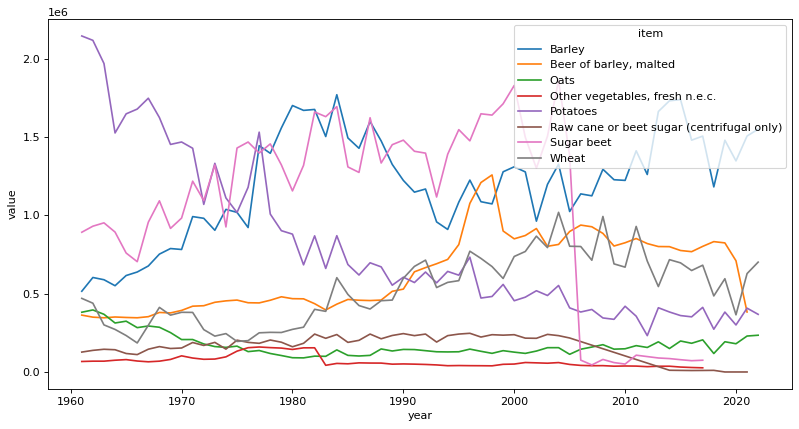

In [310]:
figure(figsize=(12, 6), dpi=80)
_ = sns.lineplot(data=df[(df.value > 0.0) & (df.area == 'Ireland') & (df.unit == 't') & (df['quantile'] == '75%')], x='year', y='value', hue='item')
_ = plt.show()

From: https://plotly.com/python/line-charts/

In [280]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

In [312]:
app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Dropdown(
                id="area",
                options=df.area.unique(),
                value="Ireland",
            ),
            dcc.RadioItems(
                ["25%", "50%", "75%"],
                "75%",
                id="quantile",
                inline=True,
            )
        ], style={'width': '40%', 'display': 'inline-block'}),
    ]),

    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("quantile", "value"),
    Input("area", "value"))
def update_line_chart(quantile, area):
    data=df[(df.value > 0.0) & (df.unit == 't') & (df.area == area) & (df['quantile'] == quantile)]
    fig = px.line(data, 
        x="year", y="value", color='item')
    return fig


app.run_server(debug=True)

In [295]:
app_comp = Dash(__name__)

app_comp.layout = html.Div([
        html.Div([
            dcc.Dropdown(
                id="item",
                options=df.item.unique(),
                value="Apples",
            ),
            dcc.Dropdown(
                id="metric",
                options=df.element.unique(),
                value="Production",
            ),
        ], style={'width': '48%', 'display': 'inline-block'}),
        html.Div([
            dcc.Dropdown(
                id="area1",
                options=df.area.unique(),
                value="Belgium",
            ),
            dcc.Dropdown(
                id="area2",
                options=df.area.unique(),
                value="Ireland",
            ),
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'}),

    dcc.Graph(id="graph"),
])


@app_comp.callback(
    Output("graph", "figure"), 
    Input("item", "value"),
    Input("metric", "value"),
    Input("area1", "value"),
    Input("area2", "value"))
def update_line_chart(item, metric, area1, area2):
    data=df[(df.value > 0.0) & (df.item == item) & (df.element == metric) & ((df.area == area1) | (df.area == area2))]
    fig = px.line(data, 
        x="year", y="value", color='area')
    return fig


app_comp.run_server(debug=True, port=8051)

In [5]:
# https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas
df_2 = pd.read_csv('/Users/olenapleshan/data_analytics/ca2-sem1/FoodBalanceSheets_E_All_Data/FoodBalanceSheets_E_All_Data_NOFLAG.csv', engine='python', encoding = "ISO-8859-1")

# Statistics

1. Compare to New Zeland https://www.quora.com/What-are-some-countries-that-are-like-Ireland
2. Use 5 tests

  Obtaining dependency information for TextBlob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 3.0 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Time Series

## Clustering

## Sentiment Analysis

In [ ]:
https://www.kaggle.com/code/michawilkosz/twitter-sentiment-analysis-using-tensorflow